In [10]:
%matplotlib inline
import os
import random
import numpy as np
import json
import matplotlib.pyplot
import cPickle as pickle
from matplotlib.pyplot import imshow
from PIL import Image
from sklearn.manifold import TSNE
from tqdm import tqdm

In [12]:
images, pca_features = pickle.load(open('../output-ml4a/features_pca_base.p', 'r'))

for i, f in zip(images, pca_features)[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(i, f[0], f[1], f[2], f[3]))

image: ../images/scaled/de45e828f983315577f773cd5fd57d97.jpg, features: -9.64,-17.49,-3.59,4.11... 
image: ../images/scaled/071d0bdbc6c5a7e9407c8d4609659d7f.jpg, features: -28.65,12.74,0.01,14.12... 
image: ../images/scaled/f9dd4da3049ae2d2294d382c73263b01.jpg, features: 3.01,-25.20,6.25,8.84... 
image: ../images/scaled/83c3bc6451179acf881583c43cb5b230.jpg, features: -11.22,5.93,13.46,-1.40... 
image: ../images/scaled/e14208b8b8dac90760589e5a63baab84.jpg, features: -17.08,-4.68,0.25,-20.71... 


In [13]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2275 samples in 0.092s...
[t-SNE] Computed neighbors for 2275 samples in 3.398s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2275
[t-SNE] Computed conditional probabilities for sample 2000 / 2275
[t-SNE] Computed conditional probabilities for sample 2275 / 2275
[t-SNE] Mean sigma: 15.343976
[t-SNE] Computed conditional probabilities in 0.192s
[t-SNE] Iteration 50: error = 78.2981262, gradient norm = 0.0526668 (50 iterations in 8.297s)
[t-SNE] Iteration 100: error = 78.2736359, gradient norm = 0.0281566 (50 iterations in 9.664s)
[t-SNE] Iteration 150: error = 78.3115768, gradient norm = 0.0557982 (50 iterations in 10.295s)
[t-SNE] Iteration 200: error = 78.2766113, gradient norm = 0.0405421 (50 iterations in 11.313s)
[t-SNE] Iteration 250: error = 78.2697525, gradient norm = 0.0186401 (50 iterations in 11.930s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.269753
[t-SNE] Iteration 300: 

In [14]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

100%|██████████| 2275/2275 [00:12<00:00, 175.51it/s]


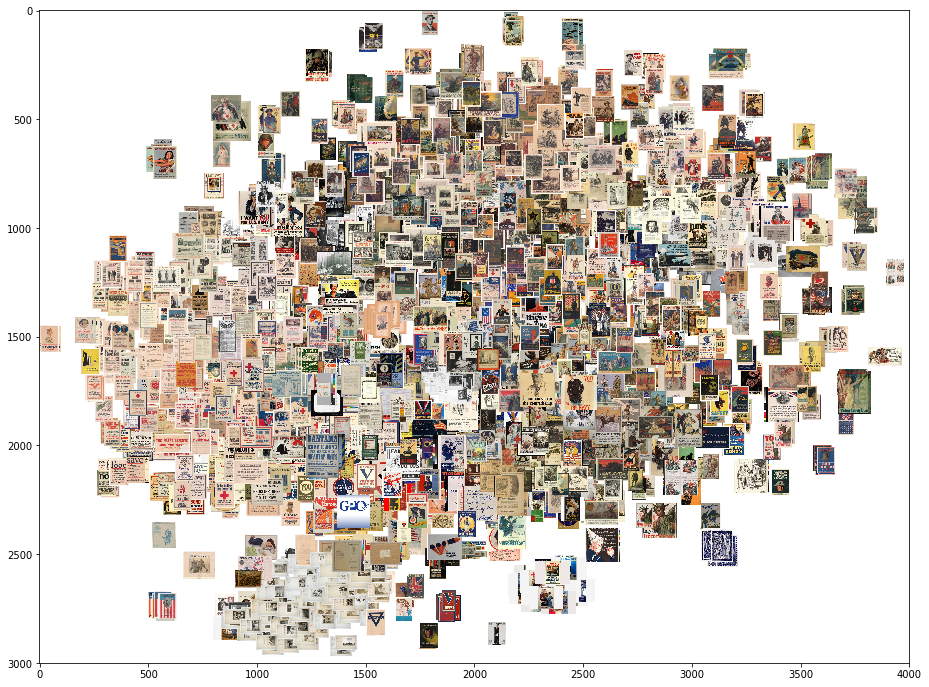

In [15]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in tqdm(zip(images, tx, ty)):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

In [16]:
full_image.save("../output-ml4a/example-tSNE.png")

In [18]:
tsne_path = "../output-ml4a/example-tSNE-points.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)

saved t-SNE result to ../output-ml4a/example-tSNE-points.json


In [48]:
import rasterfairy

# nx * ny ≈ the number of images
nx = 53
ny = 43

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

In [60]:
tile_width = 60
tile_height = 80

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in tqdm(zip(images, grid_assignment[0])):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

100%|██████████| 2275/2275 [00:14<00:00, 161.28it/s]


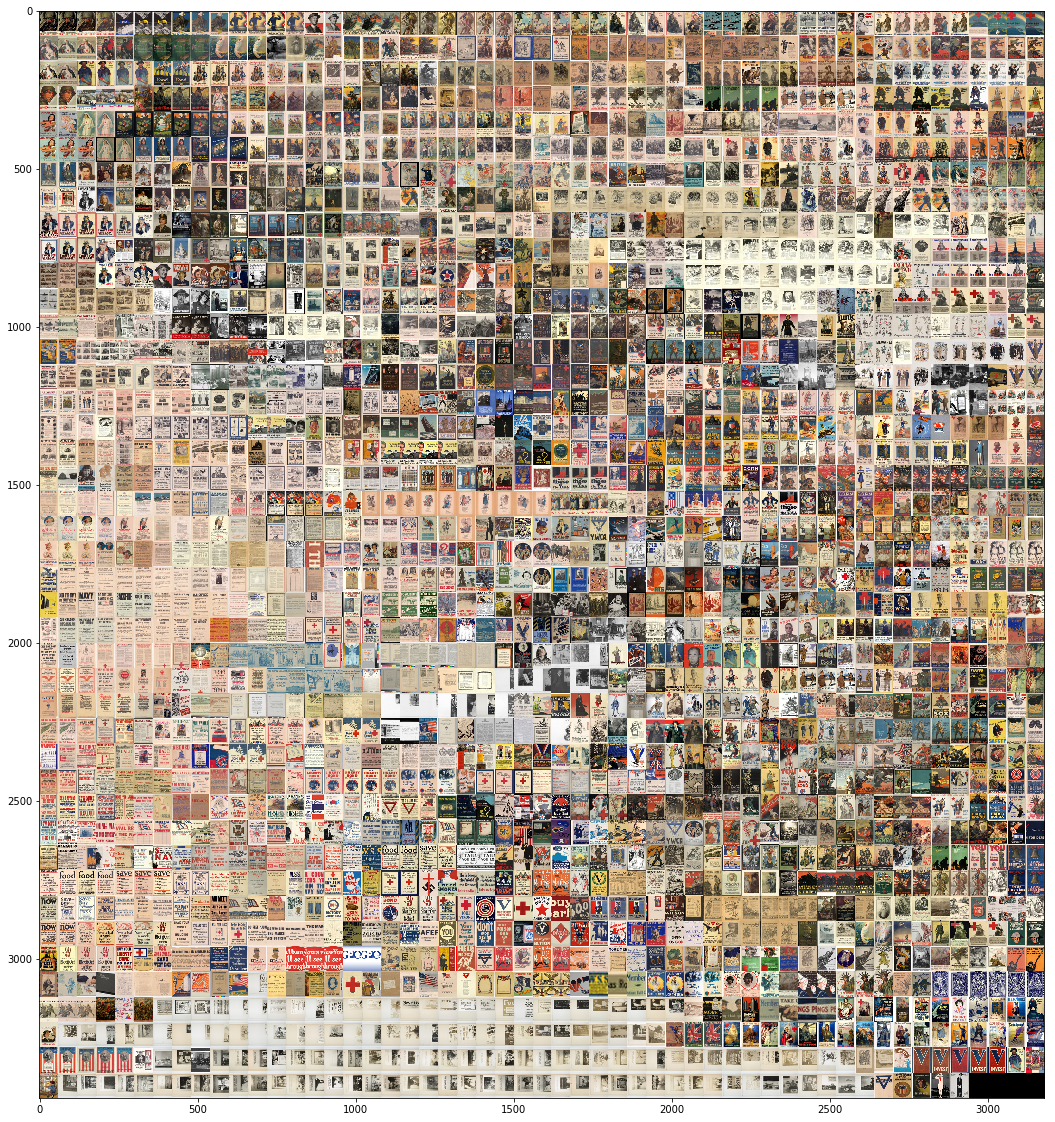

In [61]:
matplotlib.pyplot.figure(figsize = (20,20))
imshow(grid_image)

In [62]:
grid_image.save("../output-ml4a/example-tSNE-grid.jpg")